We start by installing TensorFlow and scikit-learn and importing all necessary Python libraries. These include tools for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and deep learning (Keras/TensorFlow).

In [2]:
!pip install tensorflow scikit-learn shap

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers


Here we load the Telco Customer Churn dataset into a pandas DataFrame. We also clean TotalCharges, handle missing values, encode the target column, and drop the unique customer ID since it has no predictive power.

In [3]:
# Load data
df = pd.read_csv("/content/Customer_churn_data.csv")

# Rename columns (strip spaces)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Drop obviously bad rows
df = df[df['age'].between(0, 100)]          # remove age <0 or >100
df = df[df['frequency_of_use'] >= 0]        # no negatives

# Convert object columns to numeric
for col in ['call__failure', 'complains', 'charge__amount', 'seconds_of_use']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing target or major features
df = df.dropna(subset=['churn'])

# Impute remaining missing numeric values with median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


This step prepares the data for modeling. We one-hot encode categorical variables, split the dataset into training and testing sets, and scale numeric features to improve training stability.

In [4]:
X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


We define a deep neural network with three hidden layers, batch normalization, and dropout to avoid overfitting. The output layer uses a sigmoid activation to produce the probability that a customer will churn.

In [5]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

The model is trained on the training set while monitoring validation loss. Early stopping prevents overfitting, and class weights correct for the imbalance between customers who churn and those who stay.

In [6]:
# Handle class imbalance
neg, pos = np.bincount(y_train)
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

early_stop = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor="val_loss"
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5812 - loss: 0.6728 - val_accuracy: 0.6874 - val_loss: 0.5412
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6844 - loss: 0.5004 - val_accuracy: 0.7174 - val_loss: 0.4966
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7480 - loss: 0.4477 - val_accuracy: 0.7475 - val_loss: 0.4402
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7315 - loss: 0.4687 - val_accuracy: 0.7655 - val_loss: 0.4161
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7517 - loss: 0.4208 - val_accuracy: 0.7936 - val_loss: 0.3818
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7652 - loss: 0.4188 - val_accuracy: 0.7735 - val_loss: 0.3997
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7613 - loss: 0.4067 - val_accuracy: 0.7756 - val_loss: 0.3993
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7643 - loss: 0.4043 - val_accuracy: 0.7595 - v

After training, we evaluate model performance using accuracy, precision, recall, F1-score, and ROC-AUC. Visualizations such as the confusion matrix and ROC curve help understand how well the network distinguishes churners from non-churners.

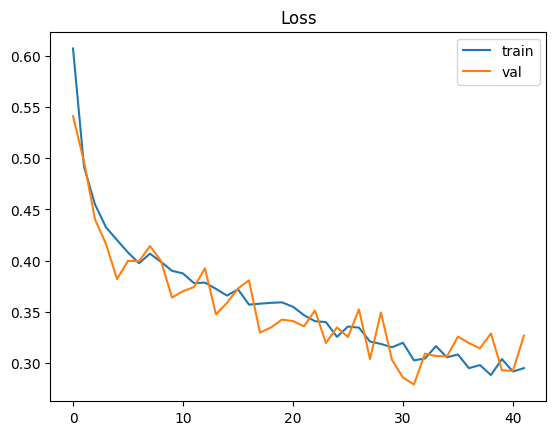

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0      0.984     0.812     0.890       528
           1      0.473     0.927     0.627        96

    accuracy                          0.830       624
   macro avg      0.729     0.870     0.758       624
weighted avg      0.905     0.830     0.850       624

ROC-AUC: 0.9419783775252526


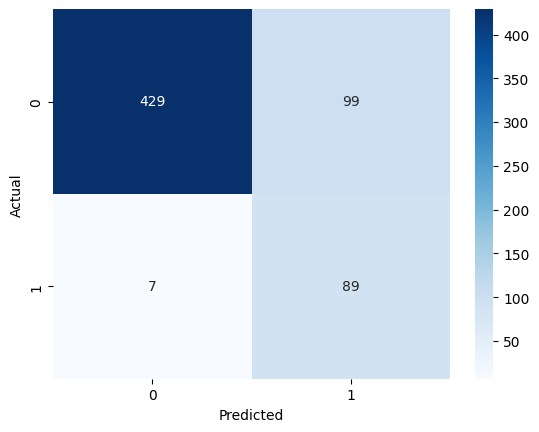

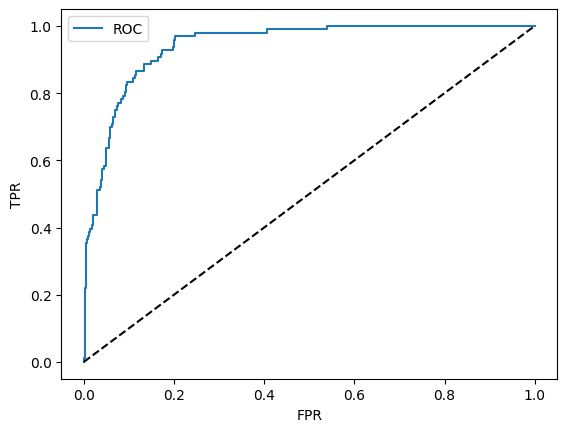

In [7]:
# Learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(); plt.title("Loss"); plt.show()

# Predictions
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()


SHAP values provide interpretability by showing how each feature contributes to churn predictions. The beeswarm plot below ranks features by importance and shows their effect on the output probability.

PermutationExplainer explainer: 201it [00:41,  4.82it/s]


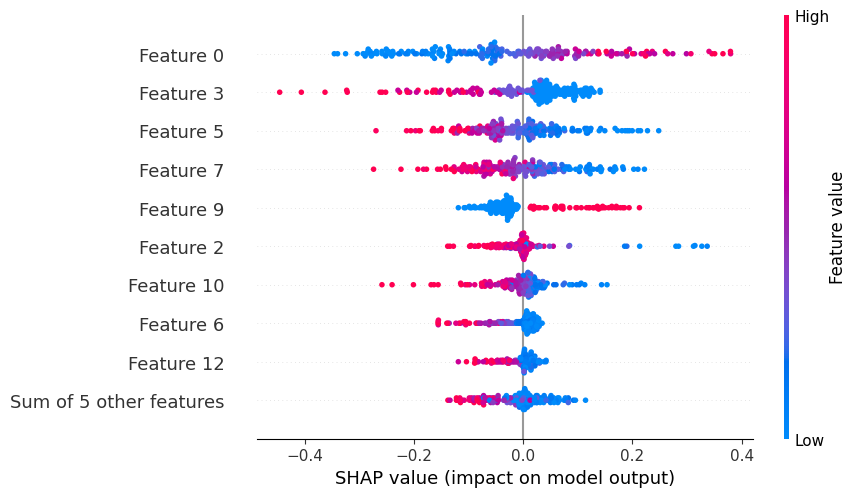

In [8]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test[:200])
shap.plots.beeswarm(shap_values)
